<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [9. Using Deep Learning to Classify Handwritten Digits](09.00-Using-Deep-Learning-to-Classify-Handwritten-Digits.ipynb) | [Contents](../README.md) | [Implementing a Multi-Layer Perceptron (MLP) in OpenCV](09.02-Implementing-a-Multi-Layer-Perceptron-in-OpenCV.ipynb) >

# Understanding Perceptrons

In the 1950s, American psychologist and artificial intelligence researcher Frank Rosenblatt invented an algorithm that would automatically learn the optimal weight coefficients $w_0$ and $w_1$ needed to perform an accurate binary classification: the perceptron learning rule.

Rosenblatt's original perceptron algorithm can be summed up as follows:

1. Initialize the weights to zero or some small random numbers.
2. For each training sample $s_i$, perform the following steps:
   1. Compute the predicted target value $ŷ_i$.
   2. Compare $ŷ_i$ to the ground truth $y_i$, and update the weights accordingly:
      - If the two are the same (correct prediction), skip ahead.
      - If the two are different (wrong prediction), push the weight coefficients $w_0$ and $w_1$ towards the positive or negative target class respectively.

## Implemeting our first perceptron

Perceptrons are easy enough to be implemented from scratch. We can mimic the typical OpenCV or scikit-learn implementation of a classifier by creating a `Perceptron` object. This will allow us to initialize new perceptron objects that can learn from data via a `fit` method and make predictions via a separate `predict` method.

When we initialize a new perceptron object, we want to pass a learning rate (`lr`) and the number of iterations after which the algorithm should terminate (`n_iter`):

In [1]:
import numpy as np
class Perceptron(object):

    def __init__(self, lr=0.01, n_iter=10):
        """Constructor
        
        Parameters
        ----------
        lr : float
            Learning rate.
        n_iter : int
            Number of iterations after which the algorithm should
            terminate.
        """
        self.lr = lr
        self.n_iter = n_iter
        
    def predict(self, X):
        """Predict target labels
        
        Parameters
        ----------
        X : array-like
            Feature matrix, <n_samples x n_features>
            
        Returns
        -------
        Predicted target labels, +1 or -1.
        
        Notes
        -----
        Must run `fit` first.
        """
        # Whenever the term (X * weights + bias) >= 0, we return
        # label +1, else we return label -1
        return np.where(np.dot(X, self.weights) + self.bias >= 0.0,
                        1, -1)
        
    def fit(self, X, y):
        """Fit the model to data
        
        Parameters
        ----------
        X : array-like
            Feature matrix, <n_samples x n_features>
        y : array-like
            Vector of target labels, <n_samples x 1>
        """
        self.weights = np.zeros(X.shape[1])
        self.bias = 0.0
        for _ in range(self.n_iter):
            for xi, yi in zip(X, y):
                delta = self.lr * (yi - self.predict(xi))
                self.weights += delta * xi
                self.bias += delta

## Generating a toy dataset

To test our perceptron classifier, we need to create some mock data. Let's keep things simple for now and generate 100 data samples (`n_samples`) belonging to one of two blobs (`center`s), again relying on scikit-learn's `make_blobs` function:

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=100, centers=2,
                  cluster_std=2.2, random_state=42)

Adjust the labels so they're either +1 or -1:

In [3]:
y = 2 * y - 1

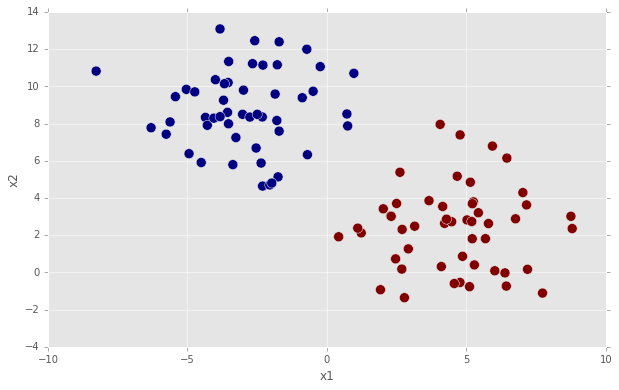

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=100, c=y);
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('perceptron-data.png')

## Fitting the perceptron to data

We can instantiate our perceptron object similar to other classifiers we encountered with
OpenCV:

In [5]:
p = Perceptron(lr=0.1, n_iter=10)

In [6]:
p.fit(X, y)

Let's have a look at the learned weights:

In [7]:
p.weights

array([ 2.20091094, -0.4798926 ])

In [8]:
p.bias

0.20000000000000001

If we plug these values into our equation for $ϕ$, it becomes clear that the perceptron learned
a decision boundary of the form $2.2 x_1 - 0.48 x_2 + 0.2 >= 0$.

## Evaluating the perceptron classifier

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(p.predict(X), y)

1.0

In [10]:
def plot_decision_boundary(classifier, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_hypo = np.c_[xx.ravel().astype(np.float32),
                   yy.ravel().astype(np.float32)]
    zz = classifier.predict(X_hypo)
    zz = zz.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

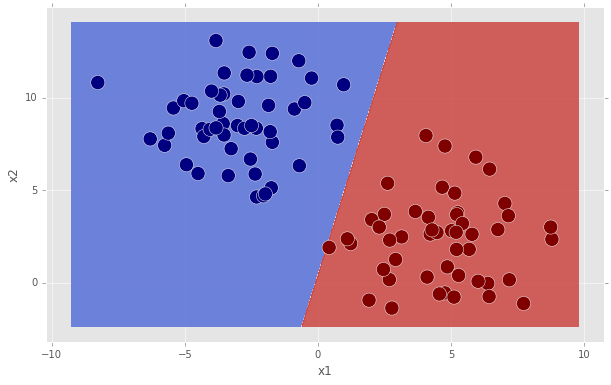

In [11]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(p, X, y)
plt.xlabel('x1')
plt.ylabel('x2')

## Applying the perceptron to data that is not linearly separable

Since the perceptron is a linear classifier, you can imagine that it would have trouble trying
to classify data that is not linearly separable. We can test this by increasing the spread
(`cluster_std`) of the two blobs in our toy dataset so that the two blobs start overlapping:

In [12]:
X, y = make_blobs(n_samples=100, centers=2,
                  cluster_std=5.2, random_state=42)
y = 2 * y - 1

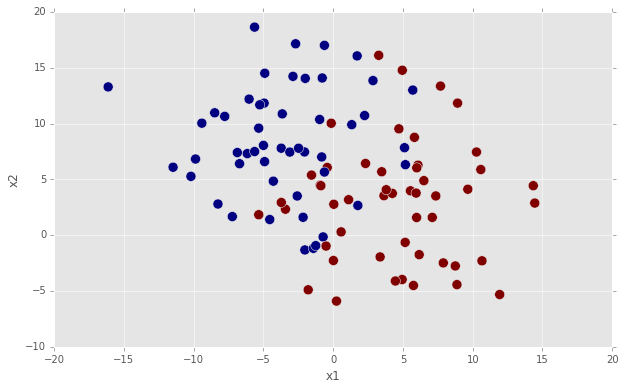

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=100, c=y);
plt.xlabel('x1')
plt.ylabel('x2')

So what would happen if we applied the perceptron classifier to this dataset?

In [14]:
p = Perceptron(lr=0.1, n_iter=10)
p.fit(X, y)

In [15]:
accuracy_score(p.predict(X), y)

0.81000000000000005

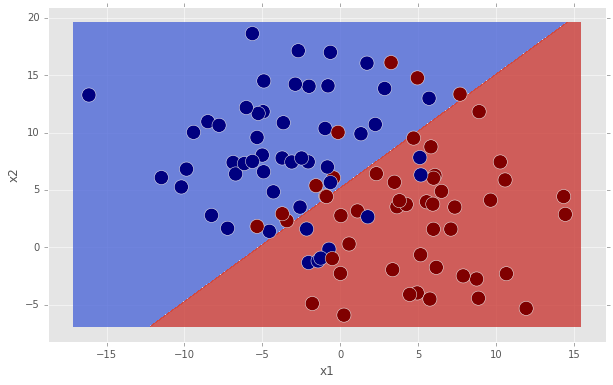

In [16]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(p, X, y)
plt.xlabel('x1')
plt.ylabel('x2')

Fortunately, there are ways to make the perceptron more powerful and ultimately create
nonlinear decision boundaries.

<!--NAVIGATION-->
< [9. Using Deep Learning to Classify Handwritten Digits](09.00-Using-Deep-Learning-to-Classify-Handwritten-Digits.ipynb) | [Contents](../README.md) | [Implementing a Multi-Layer Perceptron (MLP) in OpenCV](09.02-Implementing-a-Multi-Layer-Perceptron-in-OpenCV.ipynb) >